In [1]:
def analyze_and_visualize_results(results_data, model_name):
    """
    Args:
        results_data: Experimental Results List (each componet is dict)
        model_name: model name (str)
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # DataFrame 생성
    summary_df = pd.DataFrame(results_data)

    # ========================================================================
    # 1. 결과 요약 출력
    # ========================================================================
    print("="*80)
    print(f"Experimental Results - {model_name}")
    print("="*80)
    print(summary_df.to_string(index=False))
    print("="*80)

    # 피벗 테이블 생성
    pivot_df = summary_df.pivot(index='dataset', columns='prompt_type', values='accuracy')
    pivot_df = pivot_df[['baseline', 'standard', 'extended']]

    print("\n" + "="*80)
    print("Accuracy Comparison")
    print("="*80)
    print(pivot_df.round(2))
    print("="*80)

    # 개선율 계산
    pivot_df['standard_improvement'] = pivot_df['standard'] - pivot_df['baseline']
    pivot_df['extended_improvement'] = pivot_df['extended'] - pivot_df['baseline']
    pivot_df['extended_vs_standard'] = pivot_df['extended'] - pivot_df['standard']

    print("\n" + "="*80)
    print("Improvements(%)")
    print("="*80)
    improvement_df = pivot_df[['standard_improvement', 'extended_improvement', 'extended_vs_standard']].copy()
    improvement_df.columns = ['Standard vs Baseline', 'Extended vs Baseline', 'Extended vs Standard']
    print(improvement_df.round(2))
    print("="*80)

    # 통계 요약
    mean_accuracy = pivot_df[['baseline', 'standard', 'extended']].mean()

    print("\n" + "="*80)
    print("Result Summarization")
    print("="*80)
    print(f"\nAverage Accuracy:")
    print(f"  Baseline (No CoT):    {mean_accuracy['baseline']:6.2f}%")
    print(f"  Standard CoT:         {mean_accuracy['standard']:6.2f}%")
    print(f"  Extended CoT:         {mean_accuracy['extended']:6.2f}%")

    print(f"\nAverage Improvements:")
    print(f"  Standard vs Baseline: {mean_accuracy['standard'] - mean_accuracy['baseline']:+6.2f}%p")
    print(f"  Extended vs Baseline: {mean_accuracy['extended'] - mean_accuracy['baseline']:+6.2f}%p")
    print(f"  Extended vs Standard: {mean_accuracy['extended'] - mean_accuracy['standard']:+6.2f}%p")


    print("="*80)

    # ========================================================================
    # 2. 시각화
    # ========================================================================
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (20, 15)
    plt.rcParams['font.size'] = 11

    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 3, hspace=0.6, wspace=0.4)

    # 1. 메인 바 차트
    ax1 = fig.add_subplot(gs[0:2, 0:2])
    x = range(len(pivot_df))
    width = 0.25

    bars1 = ax1.bar([i - width for i in x], pivot_df['baseline'], width,
                    label='Baseline (No CoT)', color='#ff9999', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax1.bar([i for i in x], pivot_df['standard'], width,
                    label='Standard CoT', color='#66b3ff', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars3 = ax1.bar([i + width for i in x], pivot_df['extended'], width,
                    label='Extended CoT', color='#99ff99', alpha=0.8, edgecolor='black', linewidth=1.5)

    ax1.set_xlabel('Dataset', fontsize=14, fontweight='bold', labelpad=15)
    ax1.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold', labelpad=10)
    ax1.set_title('Zero-shot CoT Performance: Baseline vs Standard vs Extended',
                  fontsize=16, fontweight='bold', pad=25)
    ax1.set_xticks(x)
    ax1.set_xticklabels(pivot_df.index, rotation=45, ha='right', fontsize=12)
    ax1.tick_params(axis='y', labelsize=11)
    ax1.tick_params(axis='x', pad=8)
    ax1.legend(loc='upper right', fontsize=12, framealpha=0.9)
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, max(pivot_df[['baseline', 'standard', 'extended']].max().max() * 1.15, 10))

    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{height:.1f}%',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 2. 평균 정확도
    ax2 = fig.add_subplot(gs[0, 2])
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    bars = ax2.bar(range(len(mean_accuracy)), mean_accuracy.values, color=colors,
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.set_title('Average Accuracy\nAcross All Datasets', fontsize=13, fontweight='bold', pad=15)
    ax2.set_ylabel('Accuracy (%)', fontsize=12, labelpad=8)
    ax2.set_xticks(range(len(mean_accuracy)))
    ax2.set_xticklabels(['Baseline', 'Standard', 'Extended'], rotation=45, ha='right', fontsize=11)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.tick_params(axis='x', pad=5)
    ax2.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}%',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 3. 개선율 히트맵
    ax3 = fig.add_subplot(gs[1, 2])
    improvement_for_heatmap = improvement_df[['Standard vs Baseline', 'Extended vs Baseline']].copy()
    improvement_for_heatmap.columns = ['Standard\nvs Baseline', 'Extended\nvs Baseline']
    sns.heatmap(improvement_for_heatmap, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                ax=ax3, cbar_kws={'label': 'Improvement (%p)'}, linewidths=1, linecolor='black',
                annot_kws={'fontsize': 10})
    ax3.set_title('Improvement over Baseline', fontsize=13, fontweight='bold', pad=15)
    ax3.set_xlabel('')
    ax3.set_ylabel('Dataset', fontsize=12, labelpad=8)
    ax3.tick_params(axis='y', labelsize=10)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0, ha='center', fontsize=10)

    # 4. 라인 플롯
    ax4 = fig.add_subplot(gs[2, :2])
    for dataset in pivot_df.index:
        values = [pivot_df.loc[dataset, 'baseline'],
                  pivot_df.loc[dataset, 'standard'],
                  pivot_df.loc[dataset, 'extended']]
        ax4.plot(['Baseline', 'Standard', 'Extended'], values,
                marker='o', linewidth=2.5, markersize=9, label=dataset, alpha=0.7)

    ax4.set_xlabel('Prompt Type', fontsize=14, fontweight='bold', labelpad=10)
    ax4.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold', labelpad=10)
    ax4.set_title('Accuracy Trends by Prompt Type', fontsize=15, fontweight='bold', pad=20)
    ax4.tick_params(axis='both', labelsize=11)
    ax4.legend(loc='best', fontsize=11, ncol=2, framealpha=0.9)
    ax4.grid(True, alpha=0.3)

    # 5. 데이터셋 난이도
    ax5 = fig.add_subplot(gs[2, 2])
    baseline_acc = pivot_df['baseline'].sort_values()
    colors_difficulty = ['#d9534f' if x < 10 else '#f0ad4e' if x < 30 else '#5cb85c' for x in baseline_acc]
    bars = ax5.barh(range(len(baseline_acc)), baseline_acc.values, color=colors_difficulty,
                    alpha=0.8, edgecolor='black', linewidth=1)
    ax5.set_yticks(range(len(baseline_acc)))
    ax5.set_yticklabels(baseline_acc.index, fontsize=11)
    ax5.set_xlabel('Baseline Accuracy (%)', fontsize=11, labelpad=8)
    ax5.set_title('Dataset Difficulty\n(by Baseline Performance)', fontsize=12, fontweight='bold', pad=15)
    ax5.tick_params(axis='x', labelsize=10)
    ax5.grid(axis='x', alpha=0.3)

    for i, (bar, val) in enumerate(zip(bars, baseline_acc.values)):
        ax5.text(val + 1.5, i, f'{val:.1f}%', va='center', fontsize=9)

    plt.suptitle(f'Zero-shot Chain-of-Thought Experiment Results\nModel: {model_name}',
                 fontsize=18, fontweight='bold', y=0.998)

    plt.tight_layout()

    # 파일명에 모델 이름 포함
    filename = f'zero_shot_cot_results_{model_name.replace("-", "_").replace(".", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\nSave the graph: {filename}")

    plt.show()

    return summary_df, pivot_df, improvement_df

Experimental Results - Mistral-7B-v0.3
   dataset prompt_type  accuracy  num_samples
multiarith    baseline     25.93           54
multiarith    standard     81.48           54
multiarith    extended     72.22           54
     gsm8k    baseline     25.00           60
     gsm8k    standard     36.67           60
     gsm8k    extended     45.00           60
      aqua    baseline      8.33           60
      aqua    standard     25.00           60
      aqua    extended     23.33           60
     svamp    baseline      3.33           60
     svamp    standard      3.33           60
     svamp    extended      0.00           60
    letter    baseline      0.00           60
    letter    standard      0.00           60
    letter    extended      0.00           60
      coin    baseline      0.00           60
      coin    standard      0.00           60
      coin    extended      0.00           60

Accuracy Comparison
prompt_type  baseline  standard  extended
dataset                 

/tmp/ipython-input-258034547.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Save the graph: zero_shot_cot_results_Mistral_7B_v0_3.png


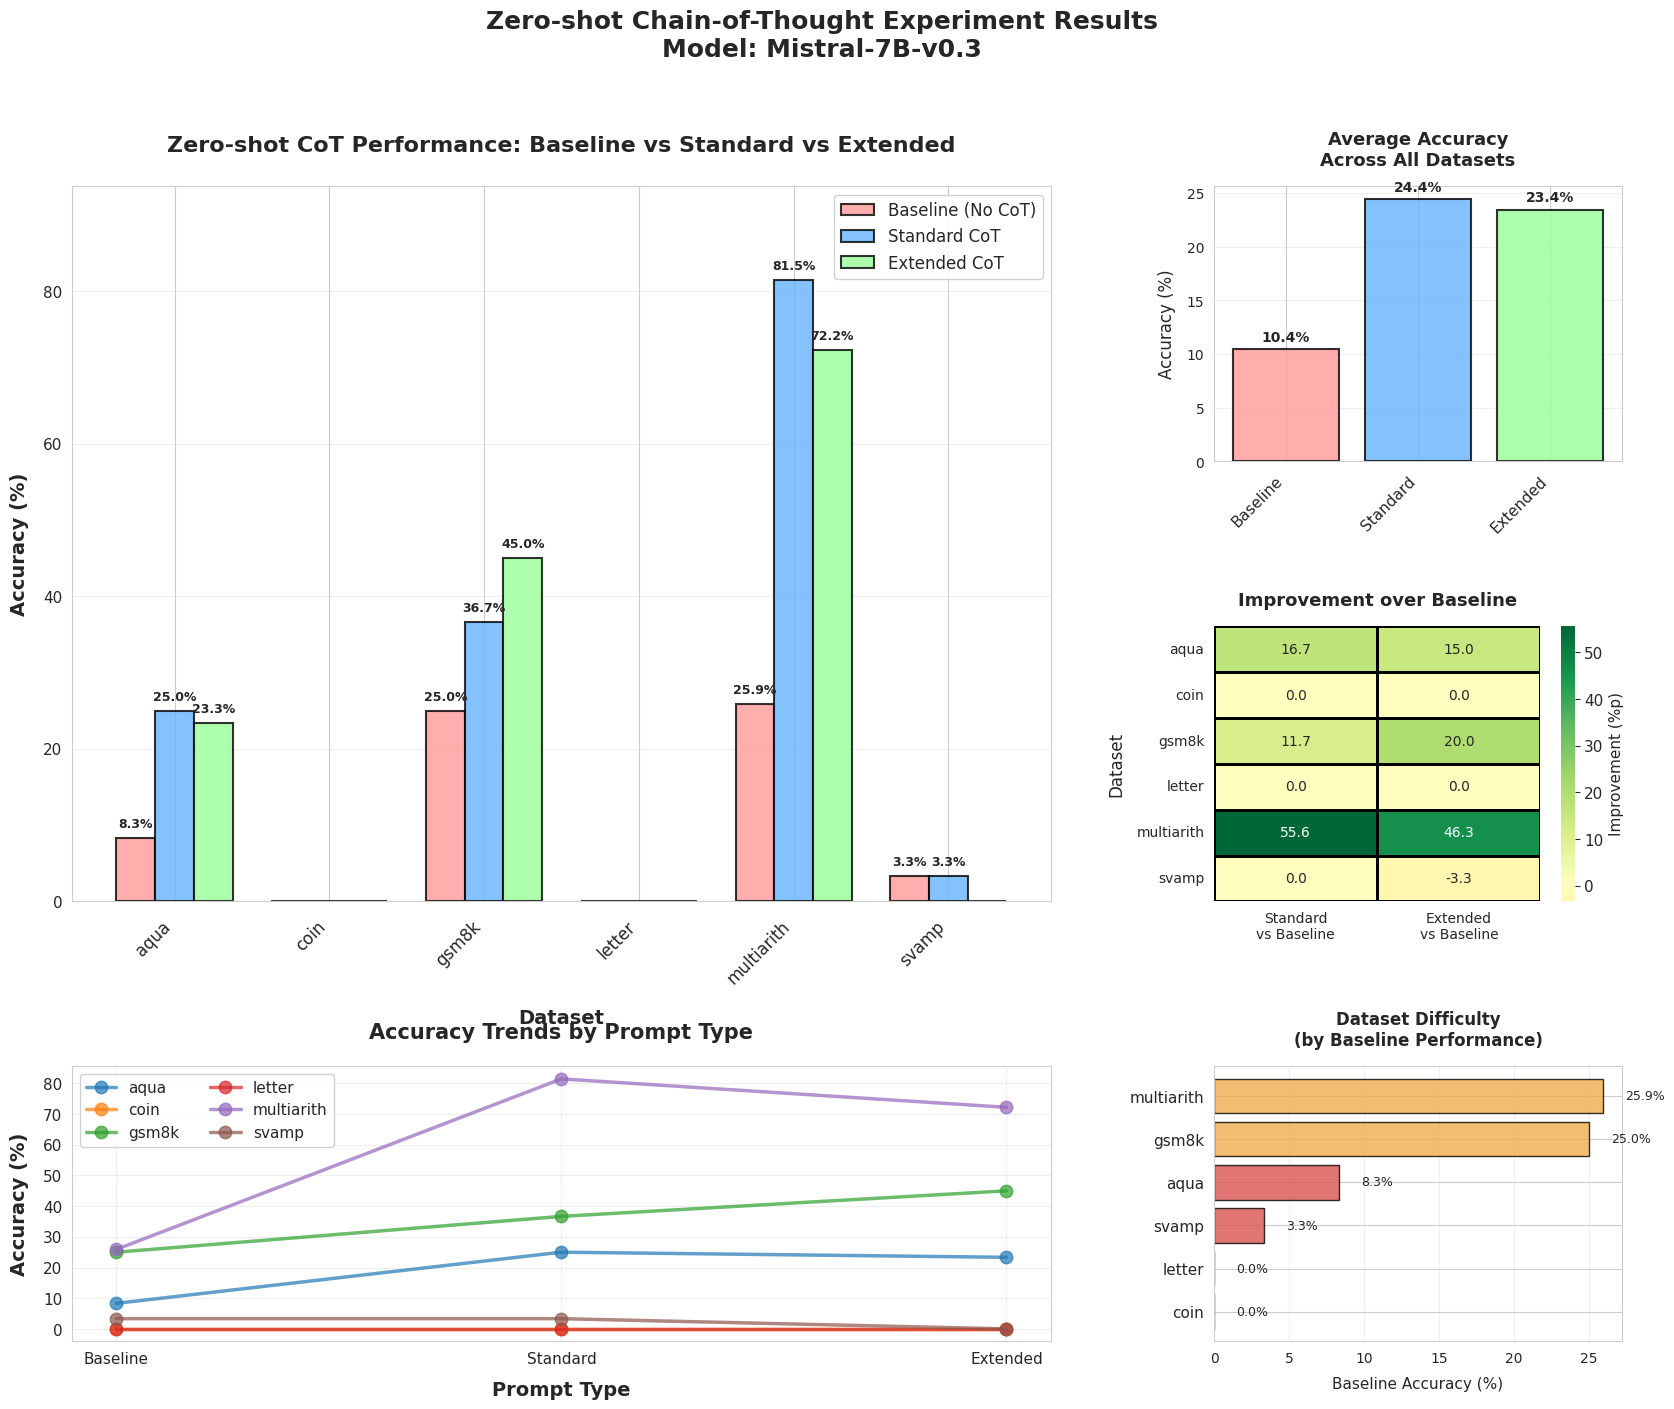

In [2]:
# Mistral-7B
mistral_results = [
    {'dataset': 'multiarith', 'prompt_type': 'baseline', 'accuracy': 25.93, 'num_samples': 54},
    {'dataset': 'multiarith', 'prompt_type': 'standard', 'accuracy': 81.48, 'num_samples': 54},
    {'dataset': 'multiarith', 'prompt_type': 'extended', 'accuracy': 72.22, 'num_samples': 54},
    {'dataset': 'gsm8k', 'prompt_type': 'baseline', 'accuracy': 25.00, 'num_samples': 60},
    {'dataset': 'gsm8k', 'prompt_type': 'standard', 'accuracy': 36.67, 'num_samples': 60},
    {'dataset': 'gsm8k', 'prompt_type': 'extended', 'accuracy': 45.00, 'num_samples': 60},
    {'dataset': 'aqua', 'prompt_type': 'baseline', 'accuracy': 8.33, 'num_samples': 60},
    {'dataset': 'aqua', 'prompt_type': 'standard', 'accuracy': 25.00, 'num_samples': 60},
    {'dataset': 'aqua', 'prompt_type': 'extended', 'accuracy': 23.33, 'num_samples': 60},
    {'dataset': 'svamp', 'prompt_type': 'baseline', 'accuracy': 3.33, 'num_samples': 60},
    {'dataset': 'svamp', 'prompt_type': 'standard', 'accuracy': 3.33, 'num_samples': 60},
    {'dataset': 'svamp', 'prompt_type': 'extended', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'letter', 'prompt_type': 'baseline', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'letter', 'prompt_type': 'standard', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'letter', 'prompt_type': 'extended', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'coin', 'prompt_type': 'baseline', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'coin', 'prompt_type': 'standard', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'coin', 'prompt_type': 'extended', 'accuracy': 0.00, 'num_samples': 60},
]

summary_df, pivot_df, improvement_df = analyze_and_visualize_results(
    mistral_results,
    "Mistral-7B-v0.3"
)

Experimental Results - Vicuna-13B-v1.5
   dataset prompt_type  accuracy  num_samples
multiarith    baseline     20.37           54
multiarith    standard     62.96           54
multiarith    extended     50.00           54
     gsm8k    baseline     21.67           60
     gsm8k    standard     21.67           60
     gsm8k    extended     18.33           60
      aqua    baseline     15.00           60
      aqua    standard     23.33           60
      aqua    extended     25.00           60
     svamp    baseline      0.00           60
     svamp    standard      1.67           60
     svamp    extended      3.33           60
    letter    baseline      0.00           60
    letter    standard      0.00           60
    letter    extended      0.00           60
      coin    baseline      0.00           60
      coin    standard      0.00           60
      coin    extended      0.00           60

Accuracy Comparison
prompt_type  baseline  standard  extended
dataset                 

/tmp/ipython-input-258034547.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Save the graph: zero_shot_cot_results_Vicuna_13B_v1_5.png


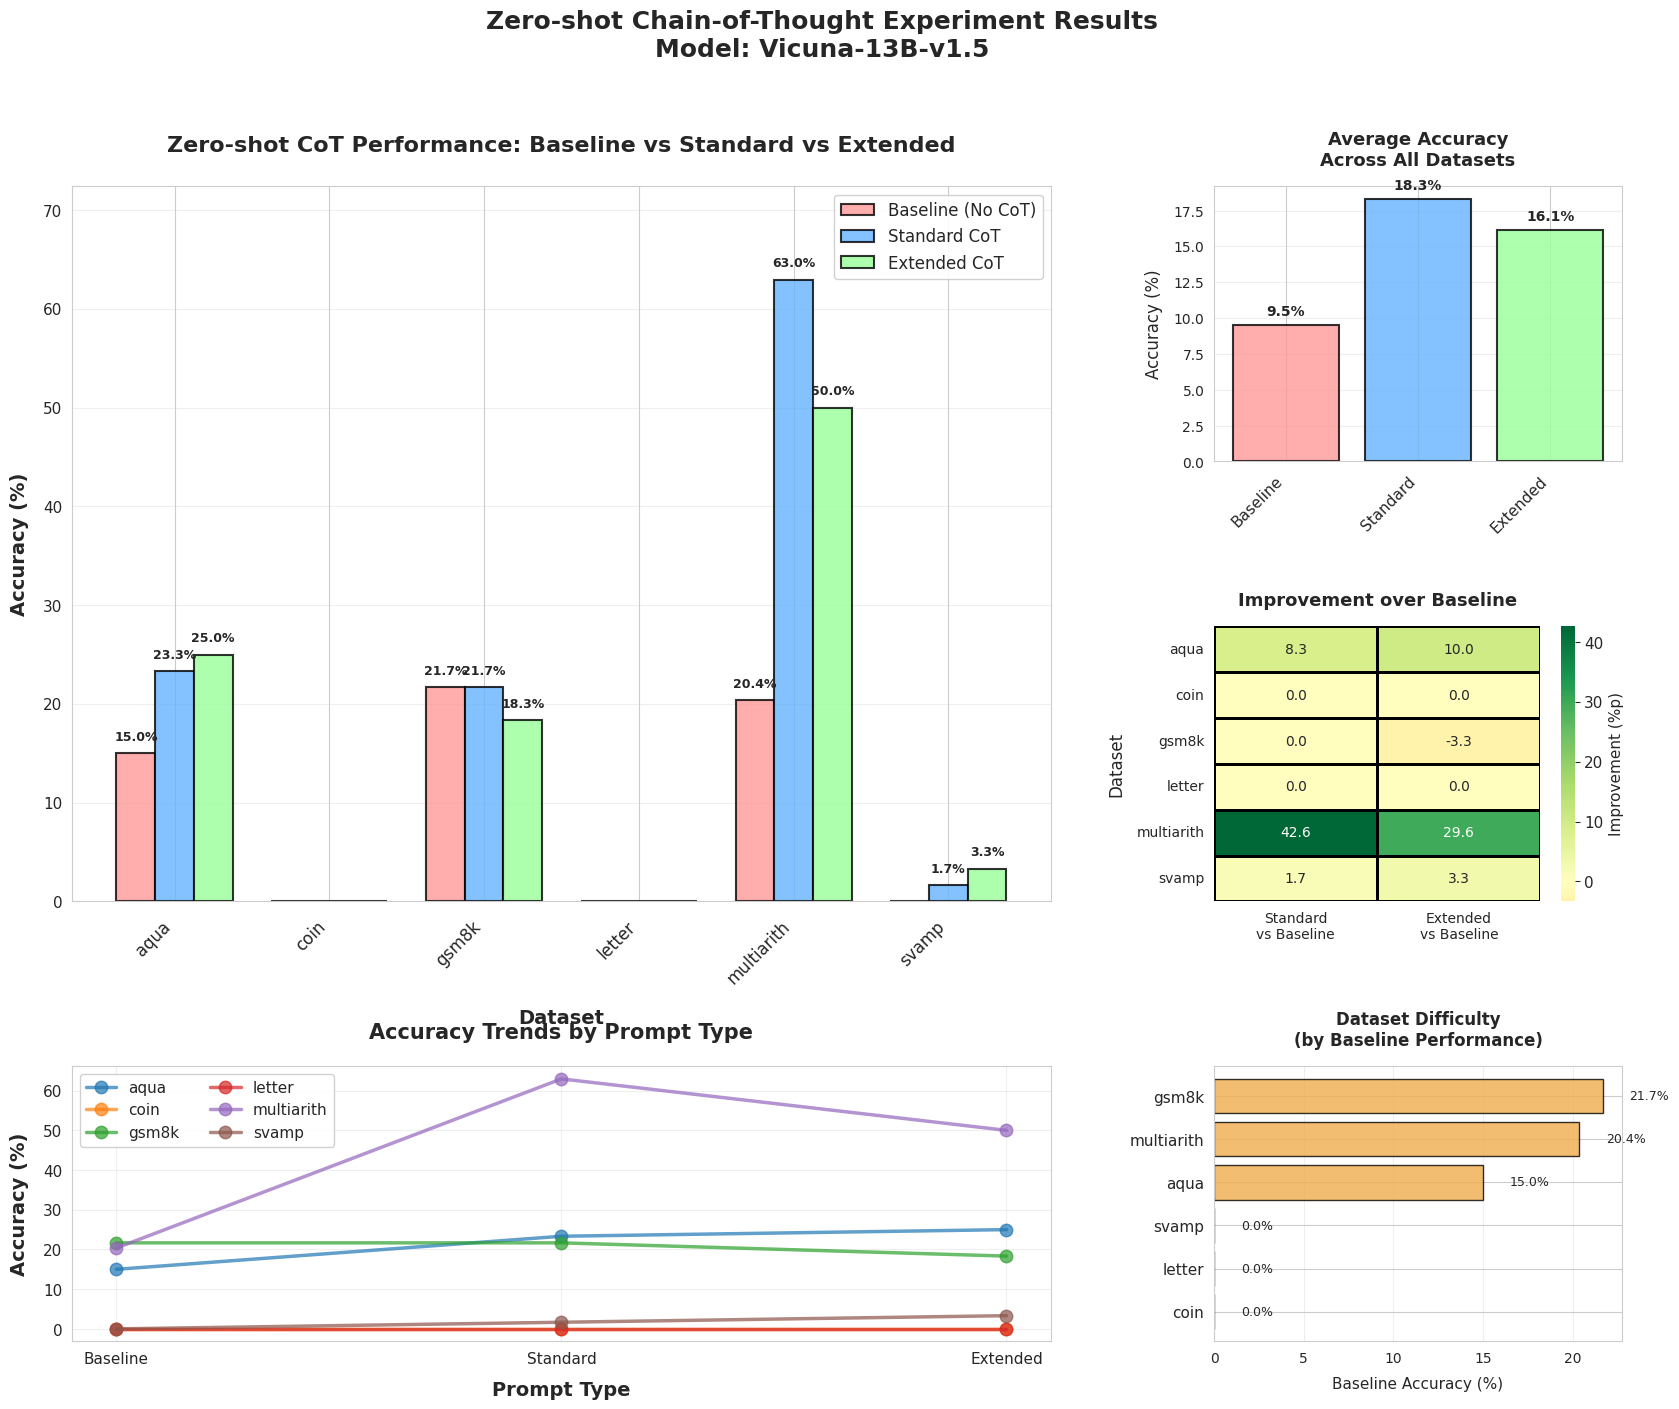

In [3]:
# Vicuna-13B 결과 데이터
vicuna_results = [
    # MultiArith
    {'dataset': 'multiarith', 'prompt_type': 'baseline', 'accuracy': 20.37, 'num_samples': 54},
    {'dataset': 'multiarith', 'prompt_type': 'standard', 'accuracy': 62.96, 'num_samples': 54},
    {'dataset': 'multiarith', 'prompt_type': 'extended', 'accuracy': 50.00, 'num_samples': 54},

    # GSM8K
    {'dataset': 'gsm8k', 'prompt_type': 'baseline', 'accuracy': 21.67, 'num_samples': 60},
    {'dataset': 'gsm8k', 'prompt_type': 'standard', 'accuracy': 21.67, 'num_samples': 60},
    {'dataset': 'gsm8k', 'prompt_type': 'extended', 'accuracy': 18.33, 'num_samples': 60},

    # AQuA
    {'dataset': 'aqua', 'prompt_type': 'baseline', 'accuracy': 15.00, 'num_samples': 60},
    {'dataset': 'aqua', 'prompt_type': 'standard', 'accuracy': 23.33, 'num_samples': 60},
    {'dataset': 'aqua', 'prompt_type': 'extended', 'accuracy': 25.00, 'num_samples': 60},

    # SVAMP
    {'dataset': 'svamp', 'prompt_type': 'baseline', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'svamp', 'prompt_type': 'standard', 'accuracy': 1.67, 'num_samples': 60},
    {'dataset': 'svamp', 'prompt_type': 'extended', 'accuracy': 3.33, 'num_samples': 60},

    # Letter
    {'dataset': 'letter', 'prompt_type': 'baseline', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'letter', 'prompt_type': 'standard', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'letter', 'prompt_type': 'extended', 'accuracy': 0.00, 'num_samples': 60},

    # Coin
    {'dataset': 'coin', 'prompt_type': 'baseline', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'coin', 'prompt_type': 'standard', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'coin', 'prompt_type': 'extended', 'accuracy': 0.00, 'num_samples': 60},
]

# Vicuna-13B 분석 및 시각화
summary_df_vicuna, pivot_df_vicuna, improvement_df_vicuna = analyze_and_visualize_results(
    vicuna_results,
    "Vicuna-13B-v1.5"
)

Experimental Results - Qwen2-7B-Instruct
   dataset prompt_type  accuracy  num_samples
multiarith    baseline     79.63           54
multiarith    standard     74.07           54
multiarith    extended     87.04           54
     gsm8k    baseline     61.67           60
     gsm8k    standard     63.33           60
     gsm8k    extended     63.33           60
      aqua    baseline     18.33           60
      aqua    standard     21.67           60
      aqua    extended     26.67           60
     svamp    baseline      3.33           60
     svamp    standard      0.00           60
     svamp    extended      1.67           60
    letter    baseline      0.00           60
    letter    standard      0.00           60
    letter    extended      0.00           60
      coin    baseline      0.00           60
      coin    standard      0.00           60
      coin    extended      0.00           60

Accuracy Comparison
prompt_type  baseline  standard  extended
dataset               

/tmp/ipython-input-258034547.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Save the graph: zero_shot_cot_results_Qwen2_7B_Instruct.png


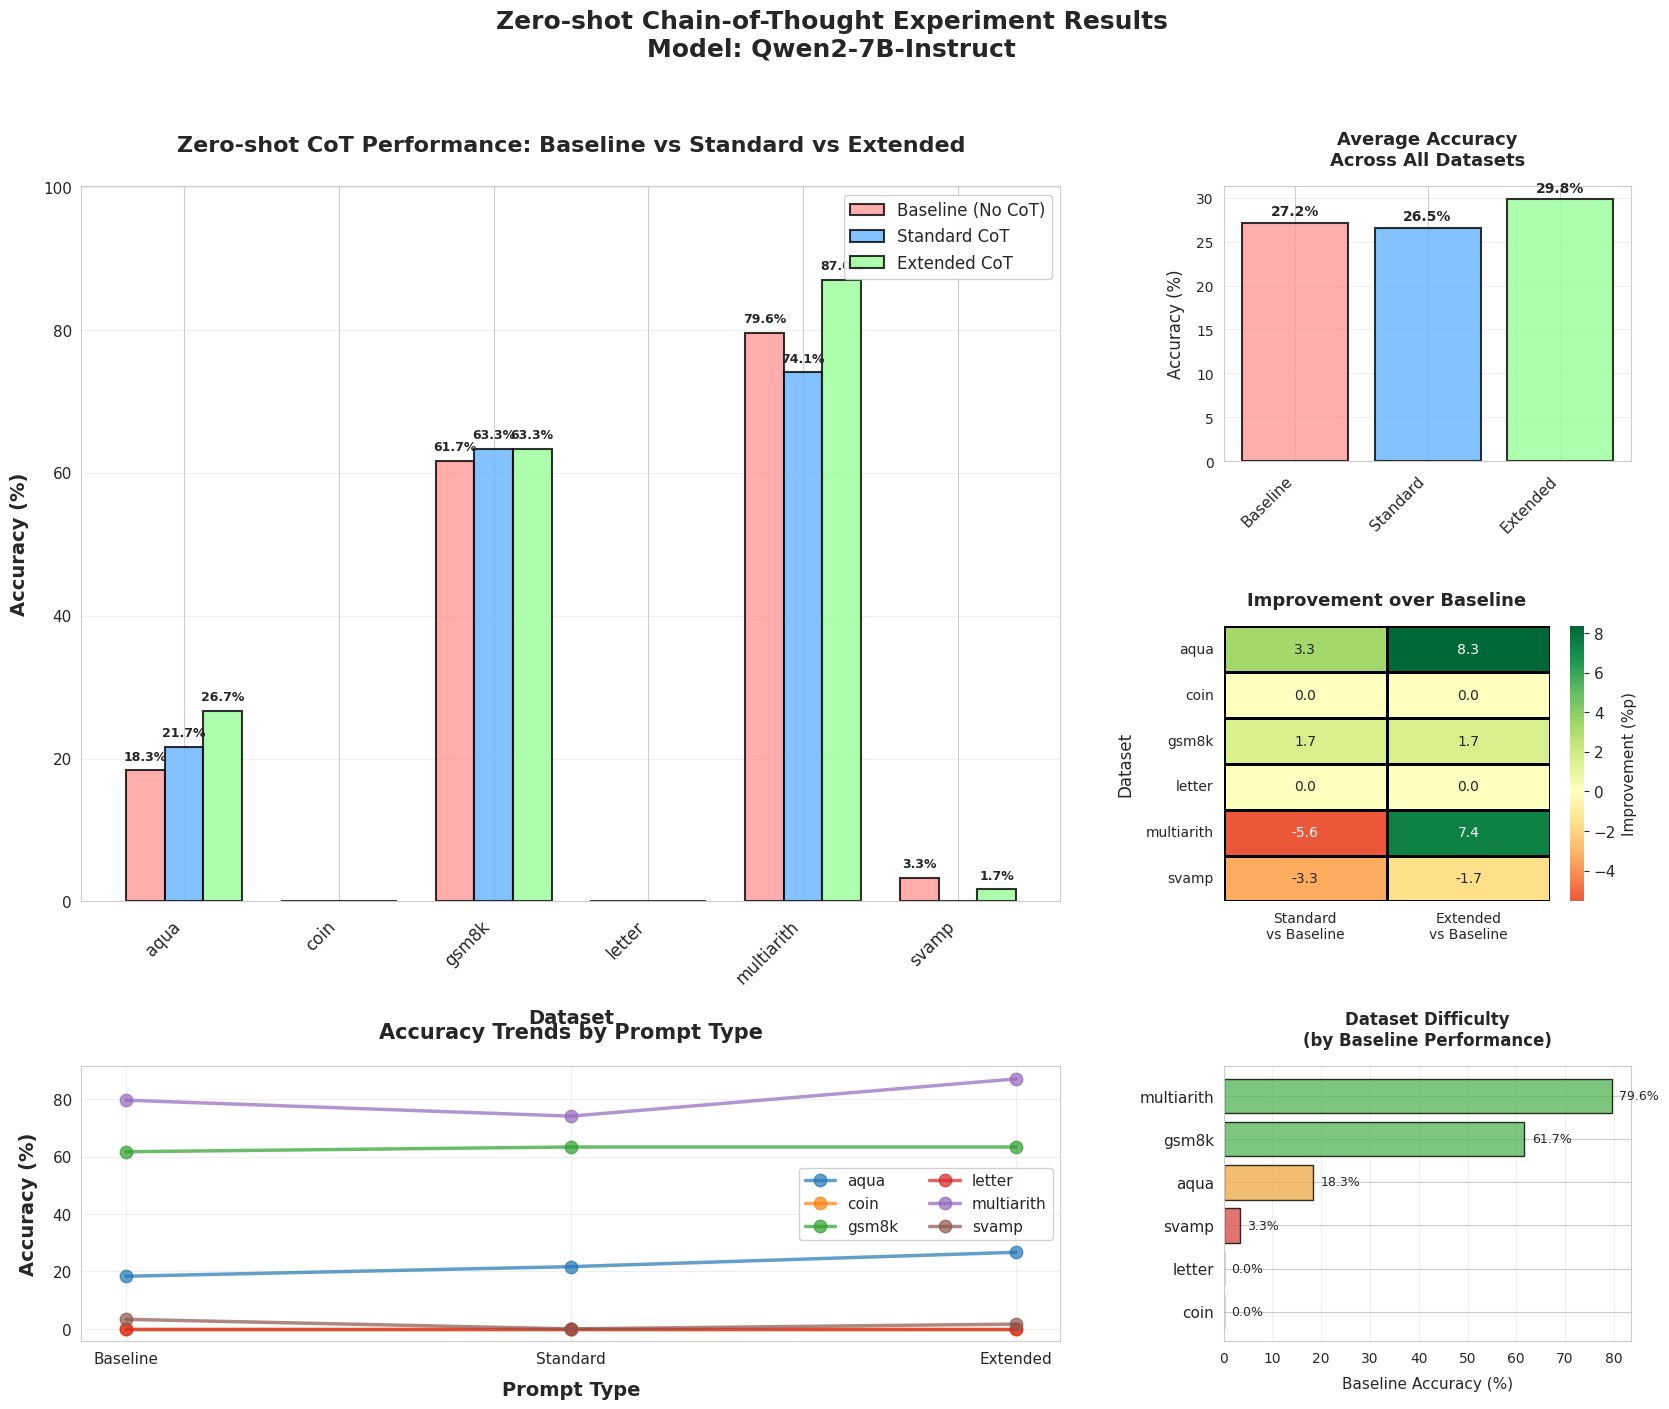

In [4]:
# Qwen2-7B
qwen_results = [
    {'dataset': 'multiarith', 'prompt_type': 'baseline', 'accuracy': 79.63, 'num_samples': 54},
    {'dataset': 'multiarith', 'prompt_type': 'standard', 'accuracy': 74.07, 'num_samples': 54},
    {'dataset': 'multiarith', 'prompt_type': 'extended', 'accuracy': 87.04, 'num_samples': 54},

    {'dataset': 'gsm8k', 'prompt_type': 'baseline', 'accuracy': 61.67, 'num_samples': 60},
    {'dataset': 'gsm8k', 'prompt_type': 'standard', 'accuracy': 63.33, 'num_samples': 60},
    {'dataset': 'gsm8k', 'prompt_type': 'extended', 'accuracy': 63.33, 'num_samples': 60},

    {'dataset': 'aqua', 'prompt_type': 'baseline', 'accuracy': 18.33, 'num_samples': 60},
    {'dataset': 'aqua', 'prompt_type': 'standard', 'accuracy': 21.67, 'num_samples': 60},
    {'dataset': 'aqua', 'prompt_type': 'extended', 'accuracy': 26.67, 'num_samples': 60},

    {'dataset': 'svamp', 'prompt_type': 'baseline', 'accuracy': 3.33, 'num_samples': 60},
    {'dataset': 'svamp', 'prompt_type': 'standard', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'svamp', 'prompt_type': 'extended', 'accuracy': 1.67, 'num_samples': 60},

    {'dataset': 'letter', 'prompt_type': 'baseline', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'letter', 'prompt_type': 'standard', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'letter', 'prompt_type': 'extended', 'accuracy': 0.00, 'num_samples': 60},

    {'dataset': 'coin', 'prompt_type': 'baseline', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'coin', 'prompt_type': 'standard', 'accuracy': 0.00, 'num_samples': 60},
    {'dataset': 'coin', 'prompt_type': 'extended', 'accuracy': 0.00, 'num_samples': 60},
]

summary_df, pivot_df, improvement_df = analyze_and_visualize_results(
    qwen_results,
    "Qwen2-7B-Instruct"
)
